# 데이터 불러오기 및 패키지 로딩

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc
from scipy import interp

### jupyter notebook

In [ ]:
HRV = pd.read_csv('HRV.csv', encoding='CP949')
EEG = pd.read_csv('EEG.csv', encoding='CP949')
clinical = pd.read_csv('clinical.csv', encoding='CP949')

EEGHRV = pd.read_csv('EEGHRV.csv', encoding='CP949')
HRVCli = pd.read_csv('HRVCli.csv', encoding='CP949')
EEGCli = pd.read_csv('EEGCli.csv', encoding='CP949')

EEGHRVCli = pd.read_csv('EEGHRVCli.csv', encoding='CP949')

In [ ]:
# 중복으로 들어간 변수 있는 지 확인
print(len(HRV.columns) == len(set(HRV.columns))) 
print(len(EEG.columns) == len(set(EEG.columns))) 
print(len(clinical.columns) == len(set(clinical.columns))) 
print(len(EEGHRV.columns) == len(set(EEGHRV.columns))) 
print(len(HRVCli.columns) == len(set(HRVCli.columns))) 
print(len(EEGCli.columns) == len(set(EEGCli.columns))) 
print(len(EEGHRVCli.columns) == len(set(EEGHRVCli.columns))) 

True
True
True
True
True
True
True


In [ ]:
HRV.columns = [re.sub("\(|\)|\-|\ ",".",HRV.columns.values[i]) for i in range(0,len(HRV.columns.values))]
EEG.columns = [re.sub("\(|\)|\-|\ ",".",EEG.columns.values[i]) for i in range(0,len(EEG.columns.values))]
clinical.columns = [re.sub("\(|\)|\-|\ ",".",clinical.columns.values[i]) for i in range(0,len(clinical.columns.values))]
EEGHRV.columns = [re.sub("\(|\)|\-|\ ",".",EEGHRV.columns.values[i]) for i in range(0,len(EEGHRV.columns.values))]
HRVCli.columns = [re.sub("\(|\)|\-|\ ",".",HRVCli.columns.values[i]) for i in range(0,len(HRVCli.columns.values))]
EEGCli.columns = [re.sub("\(|\)|\-|\ ",".",EEGCli.columns.values[i]) for i in range(0,len(EEGCli.columns.values))]
EEGHRVCli.columns = [re.sub("\(|\)|\-|\ ",".",EEGHRVCli.columns.values[i]) for i in range(0,len(EEGHRVCli.columns.values))]

In [ ]:
clinical.rename(columns = {'3.education' : 'X3.education', '5.marriage' : 'X5.marriage'}, inplace = True)
HRVCli.rename(columns = {'3.education' : 'X3.education', '5.marriage' : 'X5.marriage'}, inplace = True)
EEGCli.rename(columns = {'3.education' : 'X3.education', '5.marriage' : 'X5.marriage'}, inplace = True)
EEGHRVCli.rename(columns = {'3.education' : 'X3.education', '5.marriage' : 'X5.marriage'}, inplace = True)

# 전처리

## fold setting

In [ ]:
def sklearn_sffold_split(X,y,K):
    kf =  StratifiedKFold(n_splits = K ,shuffle=True, random_state=2022)
    result = [(train_index, test_index) for train_index, test_index in kf.split(X,y)]
    return result

## pre_processing function 

### 2-class

### input 설명
- data = 7개의 data set
- cls = 3개의 class type (지정)  -> 여기까지 총 21개의 set
- file_name = 그럼 이에 해당하는 selected features 파일 21개 중 하나 택 1 / "None" -> 전체변수
- num = 어떤 method를 쓸건지는 sheet num으로 (vanilla = 0 , vanilla - permutation = 1 , agg-per = 2)

In [ ]:
def feature_selected(feature_lst):
    
    final_lst = []
    rmv_lst = ['age','sex','group']

    for i in range(5):
        
        fold_lst = feature_lst.iloc[:,i].dropna().tolist()
        fold_lst = [s for s in fold_lst if s not in rmv_lst] # 중복방지.. 껴있으면 지우기
        fold_lst = fold_lst + rmv_lst 
        final_lst.append(fold_lst)
    
    return final_lst # 선택된 변수만 가지고 있는..

In [ ]:
def pre_process_2(data,cls,file_name,method=0): # 7개의 data , cls3개 총 21개 경우의 수해당 features 파일 , sis method(3개) , cls 3개 / 
    
    if (file_name == "None") :
        
        feature_lst = []
        for i in range(5):
            feature_lst.append(data.columns)

    else :
        feature_lst = pd.read_excel(file_name,sheet_name = method)
        feature_lst = feature_selected(feature_lst)

    X = data.drop(['group'],axis=1)
    y = data.group

    folds=sklearn_sffold_split(X,y ,5)

    train, test = [],[]

    for i in range(0,5): 
        train.append(data.iloc[folds[i][0]].reset_index(drop=True))
        test.append(data.iloc[folds[i][1]].reset_index(drop=True))
        train[i] = train[i][feature_lst[i]]

    final_train = train ; final_test = test

    # 1. HC vs. AUD
    if (cls==1):
        for i in range(5):
            final_train[i] = final_train[i].drop(final_train[i][(final_train[i]['group']=='IGD')].index, axis=0)
            final_test[i] = final_test[i].drop(final_test[i][(final_test[i]['group']=='IGD')].index, axis=0)
            final_train[i]['group'] = final_train[i].group.replace({'HC':0, 'AUD':1}).astype('category')
            final_test[i]['group'] = final_test[i].group.replace({'HC':0, 'AUD':1}).astype('category')

    # 2. HC vs. IGD
    if (cls==2):
        for i in range(5):
            final_train[i] = final_train[i].drop(final_train[i][(final_train[i]['group']=='AUD')].index, axis=0)
            final_test[i] = final_test[i].drop(final_test[i][(final_test[i]['group']=='AUD')].index, axis=0)
            final_train[i]['group'] = final_train[i].group.replace({'HC':0, 'IGD':1}).astype('category')
            final_test[i]['group'] = final_test[i].group.replace({'HC':0, 'IGD':1}).astype('category')

    # 3. HC vs. DIS
    if (cls==3):
        for i in range(5):
            final_train[i]['group'] = final_train[i].group.replace({'HC':0, 'AUD':1, 'IGD':1}).astype('category')
            final_test[i]['group'] = final_test[i].group.replace({'HC':0, 'AUD':1, 'IGD':1}).astype('category')
        
        
    return final_train , final_test

In [ ]:
# Scaling
def scaling(train,test):
    
    trains , tests = [],[]
    rmv_lst = ['group','sex','X5.marriage']
     
    for i in range(5):
        
        apend_lst = [s for s in rmv_lst if s in train[i].columns ]
        scale_lst = [s for s in train[i].columns if s not in rmv_lst]   
        
        scaler = StandardScaler()
        trains.append(pd.DataFrame(scaler.fit_transform(train[i][scale_lst]),
                                   index=train[i].index, columns=train[i][scale_lst].columns))
        trains[i][apend_lst] = train[i][apend_lst]

        
        tests.append(pd.DataFrame(scaler.transform(test[i][scale_lst]), 
                                   index=test[i].index, columns=test[i][scale_lst].columns))
        tests[i][apend_lst] = test[i][apend_lst]

    return trains, tests

## tunning function
* input : train, test, selected_vars

In [ ]:
# 2-class

In [ ]:
def Mytunning2(trains,tests):
    ela_auc, rf_auc, gbm_auc, xgb_auc =[],[],[],[]
    ela_matrix, rf_matrix, gbm_matrix, xgb_matrix = np.array([[0,0],[0,0]]),np.array([[0,0],[0,0]]),np.array([[0,0],[0,0]]),np.array([[0,0],[0,0]])

    fprs, tprs = [0,0,0,0,0],[0,0,0,0,0]
    mean_fpr = np.linspace(0,1,100)
    tprs_ela0, tprs_rf0, tprs_gbm0, tprs_xgb0  = [],[],[],[]
    
    for i in range(0,5):
        print(f'####################### fold {i} ########################')
        # train 지정 
        train = trains[i]
      
        X = train.drop('group',1)
        y = train.group
        

        ####### 모델링 #######
        # ela
        parameters = {'C':[0.001, 0.01, 0.1, 1],
                     'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}

        ela = LogisticRegression(penalty='elasticnet', solver='saga', random_state=2022)  
        grid = GridSearchCV(ela, parameters, cv=5,scoring = 'roc_auc')
        grid.fit(X, y)
        ela = grid.best_estimator_
        ela.fit(X, y)
        print(ela)


        # rf
        parameters = {'max_depth': [5, 10, 15],
                        'max_features': ['auto', 'sqrt'],
                        'min_samples_leaf': [1, 2, 4],
                        'min_samples_split': [2, 5, 10],
                        'n_estimators': [100, 200, 500]}

        rnd = RandomForestClassifier(random_state=2022)
        grid = GridSearchCV(rnd, parameters, cv=5,scoring = 'roc_auc')
        grid.fit(X, y)
        rf = grid.best_estimator_
        rf.fit(X, y)
        print(rf)

        
        # gbm
        parameters = {'max_depth': [5, 8 ,10],
                        'min_samples_leaf': [ 2, 4],
                        'min_samples_split': [2, 5],
                        'n_estimators': [100, 200, 500],
                      'learning_rate': [0.01, 0.05, 0.1]}

        gbm = GradientBoostingClassifier(random_state=2022)
        grid = GridSearchCV(gbm, parameters, cv=5,scoring = 'roc_auc')
        grid.fit(X, y)
        gbm = grid.best_estimator_
        gbm.fit(X, y)
        print(gbm)


        # xgb
        parameters = {'min_child_weight': [1, 3, 5],
                      'gamma': [0.5, 1, 1.5],
                      'max_depth': [5, 8 ,10],
                      'subsample': [0.6, 0.8],
                      'colsample_bytree': [0.6, 0.8],
                      'learning_rate' : [0.01, 0.1],
                      'n_estimators' : [100, 200, 500]}
        xgb = XGBClassifier(nthread=1, random_state=2022, eval_metric='logloss')
        grid = GridSearchCV(xgb, parameters,cv=5, scoring = 'roc_auc')
        grid.fit(X, y)
        xgb = grid.best_estimator_
        xgb.fit(X, y)
        print(xgb)


        # 각각 fold 내에서 모델마다 auc 저장 (test_score)
    
        test = tests[i]
        
        X_test = test.drop('group',1)
        y_test = test.group
        
        ela_auc.append(roc_auc_score(y_test, ela.predict_proba(X_test)[:,1]))
        rf_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
        gbm_auc.append(roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))
        xgb_auc.append(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

        ela_matrix=np.add(ela_matrix, confusion_matrix(y_test, ela.predict(X_test)))
        rf_matrix=np.add(rf_matrix, confusion_matrix(y_test, rf.predict(X_test)))
        gbm_matrix=np.add(gbm_matrix, confusion_matrix(y_test, gbm.predict(X_test)))
        xgb_matrix=np.add(xgb_matrix, confusion_matrix(y_test, xgb.predict(X_test)))

        
        # 각각 fold 내에서 모델마다 roc 저장 
        fprs[i], tprs[i], _ = roc_curve(y_test, ela.predict_proba(X_test)[:,1])
        tprs_ela0.append(interp(mean_fpr, np.stack(fprs[i]).astype('float'), np.stack(tprs[i]).astype('float')))
        
        fprs[i], tprs[i], _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
        tprs_rf0.append(interp(mean_fpr, np.stack(fprs[i]).astype('float'), np.stack(tprs[i]).astype('float')))
        
        fprs[i], tprs[i], _ = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
        tprs_gbm0.append(interp(mean_fpr, np.stack(fprs[i]).astype('float'), np.stack(tprs[i]).astype('float')))
        
        fprs[i], tprs[i], _ = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
        tprs_xgb0.append(interp(mean_fpr, np.stack(fprs[i]).astype('float'), np.stack(tprs[i]).astype('float')))
    
    print('ela_mean_auc:',np.mean(ela_auc))
    print('rf_mean_auc:',np.mean(rf_auc))
    print('gbm_mean_auc:',np.mean(gbm_auc))
    print('xgb_mean_auc:',np.mean(xgb_auc))

    # confusion matrix로 성능지표 계산
    matrix_list = [ela_matrix, rf_matrix, gbm_matrix, xgb_matrix]
    for matrix in matrix_list:
        acc = (matrix[0][0] + matrix[1][1])/sum(sum(matrix))
        rec = matrix[1][1] / (matrix[1][0]+matrix[1][1])
        pre = matrix[1][1] / (matrix[0][1]+matrix[1][1])
        f1 = 2*(rec*pre)/(rec+pre)
        print(matrix)
        print('accuracy:',np.mean(acc),'f1-score:',np.mean(f1),'recall:',np.mean(rec),'precision:',np.mean(pre))
    
    # 평균 roc 저장 
    mean_tpr_ela = np.mean(tprs_ela0, axis=0)
    mean_tpr_rf = np.mean(tprs_rf0, axis=0)
    mean_tpr_gbm = np.mean(tprs_gbm0, axis=0)
    mean_tpr_xgb = np.mean(tprs_xgb0, axis=0)

    return mean_tpr_ela, mean_tpr_rf, mean_tpr_gbm, mean_tpr_xgb

## ROC curve

In [ ]:
def plot_roc_curve_2(Mytunning2, name, dataset, filename):
    mean_tpr_ela, mean_tpr_rf, mean_tpr_gbm, mean_tpr_xgb = Mytunning2[0], Mytunning2[1], Mytunning2[2], Mytunning2[3]

    mean_tpr_ela = [0]+list(mean_tpr_ela)
    mean_tpr_rf = [0]+list(mean_tpr_rf)
    mean_tpr_gbm = [0]+list(mean_tpr_gbm)
    mean_tpr_xgb = [0]+list(mean_tpr_xgb)
    
    mean_fpr = [0]+list(np.linspace(0,1,100))
    plt.rcParams["figure.figsize"] = (7, 7)
    plt.plot(mean_fpr, mean_tpr_ela, color='red',label=r'ElasticNet',lw=1, alpha=1)
    plt.plot(mean_fpr, mean_tpr_rf, color='green',label=r'RF',lw=1, alpha=1)
    plt.plot(mean_fpr, mean_tpr_gbm, color='blue',label=r'GBM',lw=1, alpha=1)
    plt.plot(mean_fpr, mean_tpr_xgb, color='orange',label=r'XGB',lw=1, alpha=1)
    plt.plot(mean_fpr, mean_fpr, color='grey',lw=1, alpha=1, linestyle='--')
    plt.title('ROC Curve of '+ name + ' Classification ('+dataset+')')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', prop={'size': 12})
    plt.show()
    
    plt.savefig(f'{filename}.png')

# Experiment - 변수 모두 이용

# <2-class>

In [ ]:
mean_sis1_best, mean_sis2_best, mean_whole_best = cl3_vanilla40_eeghrv[몇번짼지], cl3_vanilla40_eeghrv_new[], cl3_eeghrv_whole[]

mean_sis1_best = [0]+list(mean_sis1_best)
mean_sis2_best = [0]+list(mean_sis2_best)
mean_whole_best = [0]+list(mean_whole_best)

mean_fpr = [0]+list(np.linspace(0,1,100))
plt.rcParams["figure.figsize"] = (7, 7)
plt.plot(mean_fpr, mean_sis1_best, color='red',label=r'[SIS1] 모델이름',lw=1, alpha=1)     # ElasticNet, RF, GBM, XGB
plt.plot(mean_fpr, mean_sis2_best, color='green',label=r'[SIS2] 모델이름',lw=1, alpha=1)
plt.plot(mean_fpr, mean_whole_best, color='blue',label=r'[Whole] 모델이름',lw=1, alpha=1)
plt.plot(mean_fpr, mean_fpr, color='grey',lw=1, alpha=1, linestyle='--')
plt.title('ROC Curve of '+ 어떤분류인지('HC vs. IGD') + ' Classification (EEG, HRV)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', prop={'size': 12})
plt.show()

## EEGHRV

### 1. HC vs. AUD 

In [ ]:
train,test = pre_process_2(EEGHRV, cls = 1 ,file_name = 'EEGHRV_class1_selected_vars_new.xlsx', method = 0)
train, test = scaling(train,test)
cl1_vanilla40_eeghrv_new = Mytunning2(train,test)

####################### fold 0 ########################
LogisticRegression(C=0.1, l1_ratio=0, penalty='elasticnet', random_state=2022,
                   solver='saga')
RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=500,
                       random_state=2022)
GradientBoostingClassifier(learning_rate=0.05, max_depth=10, min_samples_leaf=4,
                           n_estimators=200, random_state=2022)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=2022, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parame

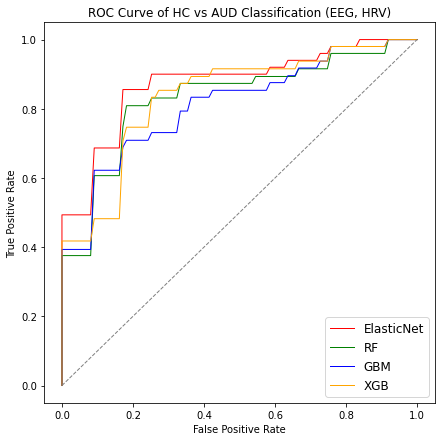

<Figure size 504x504 with 0 Axes>

In [ ]:
plot_roc_curve_2(cl1_vanilla40_eeghrv_new, 'HC vs AUD', 'EEG, HRV', 'cl1_vanilla40_eeghrv_new')

### 2. HC vs. IGD 

In [ ]:
train,test = pre_process_2(EEGHRV, cls = 2 ,file_name = 'EEGHRV_class2_selected_vars_new.xlsx', method = 0)
train, test = scaling(train,test)
cl2_vanilla40_eeghrv_new = Mytunning2(train,test)

####################### fold 0 ########################
LogisticRegression(C=0.001, l1_ratio=0, penalty='elasticnet', random_state=2022,
                   solver='saga')
RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=2022)
GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                           n_estimators=500, random_state=2022)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=2022, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

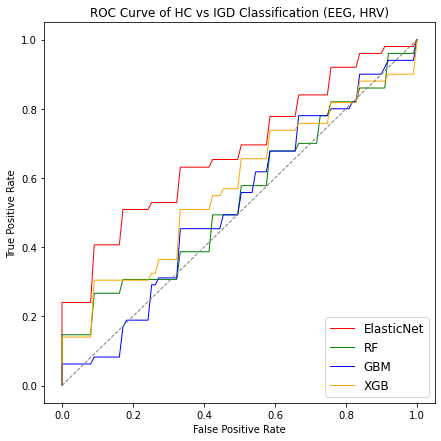

<Figure size 504x504 with 0 Axes>

In [ ]:
plot_roc_curve_2(cl2_vanilla40_eeghrv_new, 'HC vs IGD', 'EEG, HRV', 'cl2_vanilla40_eeghrv_new')

### 3. HC vs. DIS 

In [ ]:
train,test = pre_process_2(EEGHRV, cls = 3 ,file_name = 'EEGHRV_class3_selected_vars_new.xlsx', method = 0)
train, test = scaling(train,test)
cl3_vanilla40_eeghrv_new = Mytunning2(train,test)

####################### fold 0 ########################
LogisticRegression(C=0.01, l1_ratio=0, penalty='elasticnet', random_state=2022,
                   solver='saga')
RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=200,
                       random_state=2022)
GradientBoostingClassifier(learning_rate=0.05, max_depth=8, min_samples_leaf=4,
                           n_estimators=200, random_state=2022)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=2022, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parame

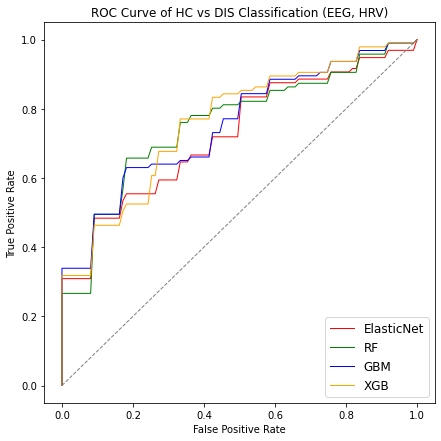

<Figure size 504x504 with 0 Axes>

In [ ]:
plot_roc_curve_2(cl3_vanilla40_eeghrv_new, 'HC vs DIS', 'EEG, HRV', 'cl3_vanilla40_eeghrv_new')

## EEGCli

### 1. HC vs. AUD 

In [ ]:
train,test = pre_process_2(EEGCli, cls = 1 ,file_name = 'EEGCli_class1_selected_vars_new.xlsx', method = 0)
train, test = scaling(train,test)
cl1_vanilla40_eegcli_new = Mytunning2(train,test)

####################### fold 0 ########################
LogisticRegression(C=0.01, l1_ratio=0, penalty='elasticnet', random_state=2022,
                   solver='saga')
RandomForestClassifier(max_depth=5, random_state=2022)
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=4,
                           n_estimators=500, random_state=2022)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=2022, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)
######################

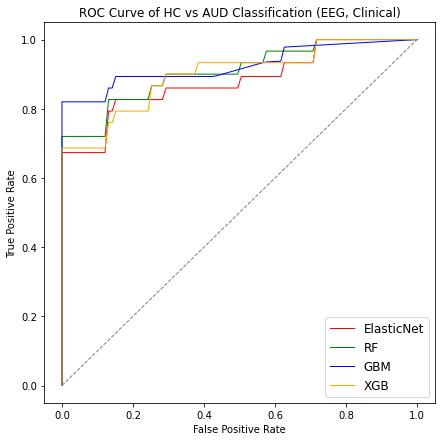

<Figure size 504x504 with 0 Axes>

In [ ]:
plot_roc_curve_2(cl1_vanilla40_eegcli_new, 'HC vs AUD', 'EEG, Clinical', 'cl1_vanilla40_eegcli_new')

### 2. HC vs. IGD 

In [ ]:
train,test = pre_process_2(EEGCli, cls = 2 ,file_name = 'EEGCli_class2_selected_vars_new.xlsx', method = 0)
train, test = scaling(train,test)
cl2_vanilla40_eegcli_new = Mytunning2(train,test)

####################### fold 0 ########################
LogisticRegression(C=0.001, l1_ratio=0, penalty='elasticnet', random_state=2022,
                   solver='saga')
RandomForestClassifier(max_depth=5, random_state=2022)
GradientBoostingClassifier(max_depth=5, min_samples_leaf=4, n_estimators=200,
                           random_state=2022)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=2022, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)
####################### fold 1 ############

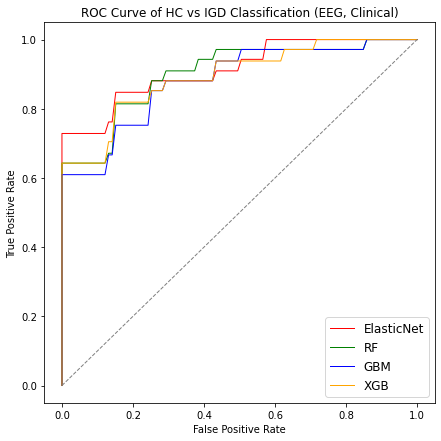

<Figure size 504x504 with 0 Axes>

In [ ]:
plot_roc_curve_2(cl2_vanilla40_eegcli_new, 'HC vs IGD', 'EEG, Clinical', 'cl2_vanilla40_eegcli_new')

### 3. HC vs. DIS 

In [ ]:
train,test = pre_process_2(EEGCli, cls = 3 ,file_name = 'EEGCli_class3_selected_vars_new.xlsx', method = 0)
train, test = scaling(train,test)
cl3_vanilla40_eegcli_new = Mytunning2(train,test)

####################### fold 0 ########################
LogisticRegression(C=0.01, l1_ratio=0, penalty='elasticnet', random_state=2022,
                   solver='saga')
RandomForestClassifier(max_depth=5, random_state=2022)
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=4,
                           n_estimators=200, random_state=2022)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=2022, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)
#######################

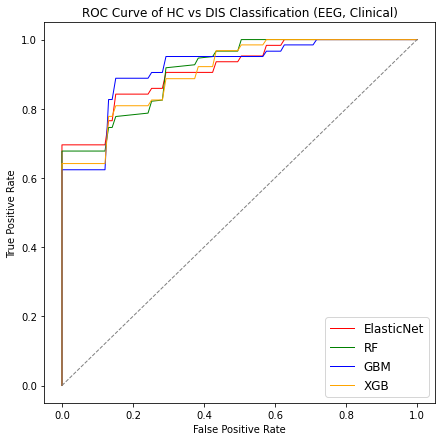

<Figure size 504x504 with 0 Axes>

In [ ]:
plot_roc_curve_2(cl3_vanilla40_eegcli_new, 'HC vs DIS', 'EEG, Clinical', 'cl3_vanilla40_eegcli_new')